# Preparing the Dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/TESI

Mounted at /gdrive
/gdrive/My Drive/TESI


In [ ]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We configure TensorFlow to work in double precision
tf.keras.backend.set_floatx('float64')

import optimization

In [ ]:
dt = 5e-1
num_latent_states = 20

In [ ]:
dataset = np.load('./data_time.npy', allow_pickle = True)[()]
dataset['points_full'] = dataset['points_full'][0]
dataset['out_fields'] = dataset['out_fields'][0]
del dataset['inp_parameters']

In [ ]:
max = np.max(dataset['out_fields'])
min = np.min(dataset['out_fields'])
dataset['out_fields'] = (2*dataset['out_fields']-max-min)/(max-min)

In [ ]:
for key in dataset.keys():
  print(key, dataset[key].shape)

times (513,)
points (256, 1)
points_full (513, 256, 1)
out_fields (513, 256, 1)


In [ ]:
dataset_train = {}
dataset_test = {}
dataset_train['points'] = dataset['points']
dataset_test['points'] = dataset['points']
index = int(np.ceil(dataset['times'].shape[0]/2))
for key in ['times', 'points_full', 'out_fields']:
  dataset_train[key] = dataset[key][:index]
  dataset_test[key] = dataset[key][index:]
dataset_train['num_times'] = dataset_train['times'].shape[0]
dataset_train['num_points'] = dataset_train['points'].shape[0]
dataset_test['num_times'] = dataset_test['times'].shape[0]
dataset_test['num_points'] = dataset_test['points'].shape[0]

In [ ]:
for key in dataset.keys():
  print(key, 'train: ', dataset_train[key].shape, ' test: ', dataset_test[key].shape)
for key in ['num_times', 'num_points']:
  print(key, 'train: ', dataset_train[key], ' test :', dataset_test[key])

times train:  (257,)  test:  (256,)
points train:  (256, 1)  test:  (256, 1)
points_full train:  (257, 256, 1)  test:  (256, 256, 1)
out_fields train:  (257, 256, 1)  test:  (256, 256, 1)
num_times train:  257  test : 256
num_points train:  256  test : 256


# Architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,764 (13.78 KB)

 Trainable params: 1,764 (13.78 KB)

 Non-trainable params: 0 (0.00 B)

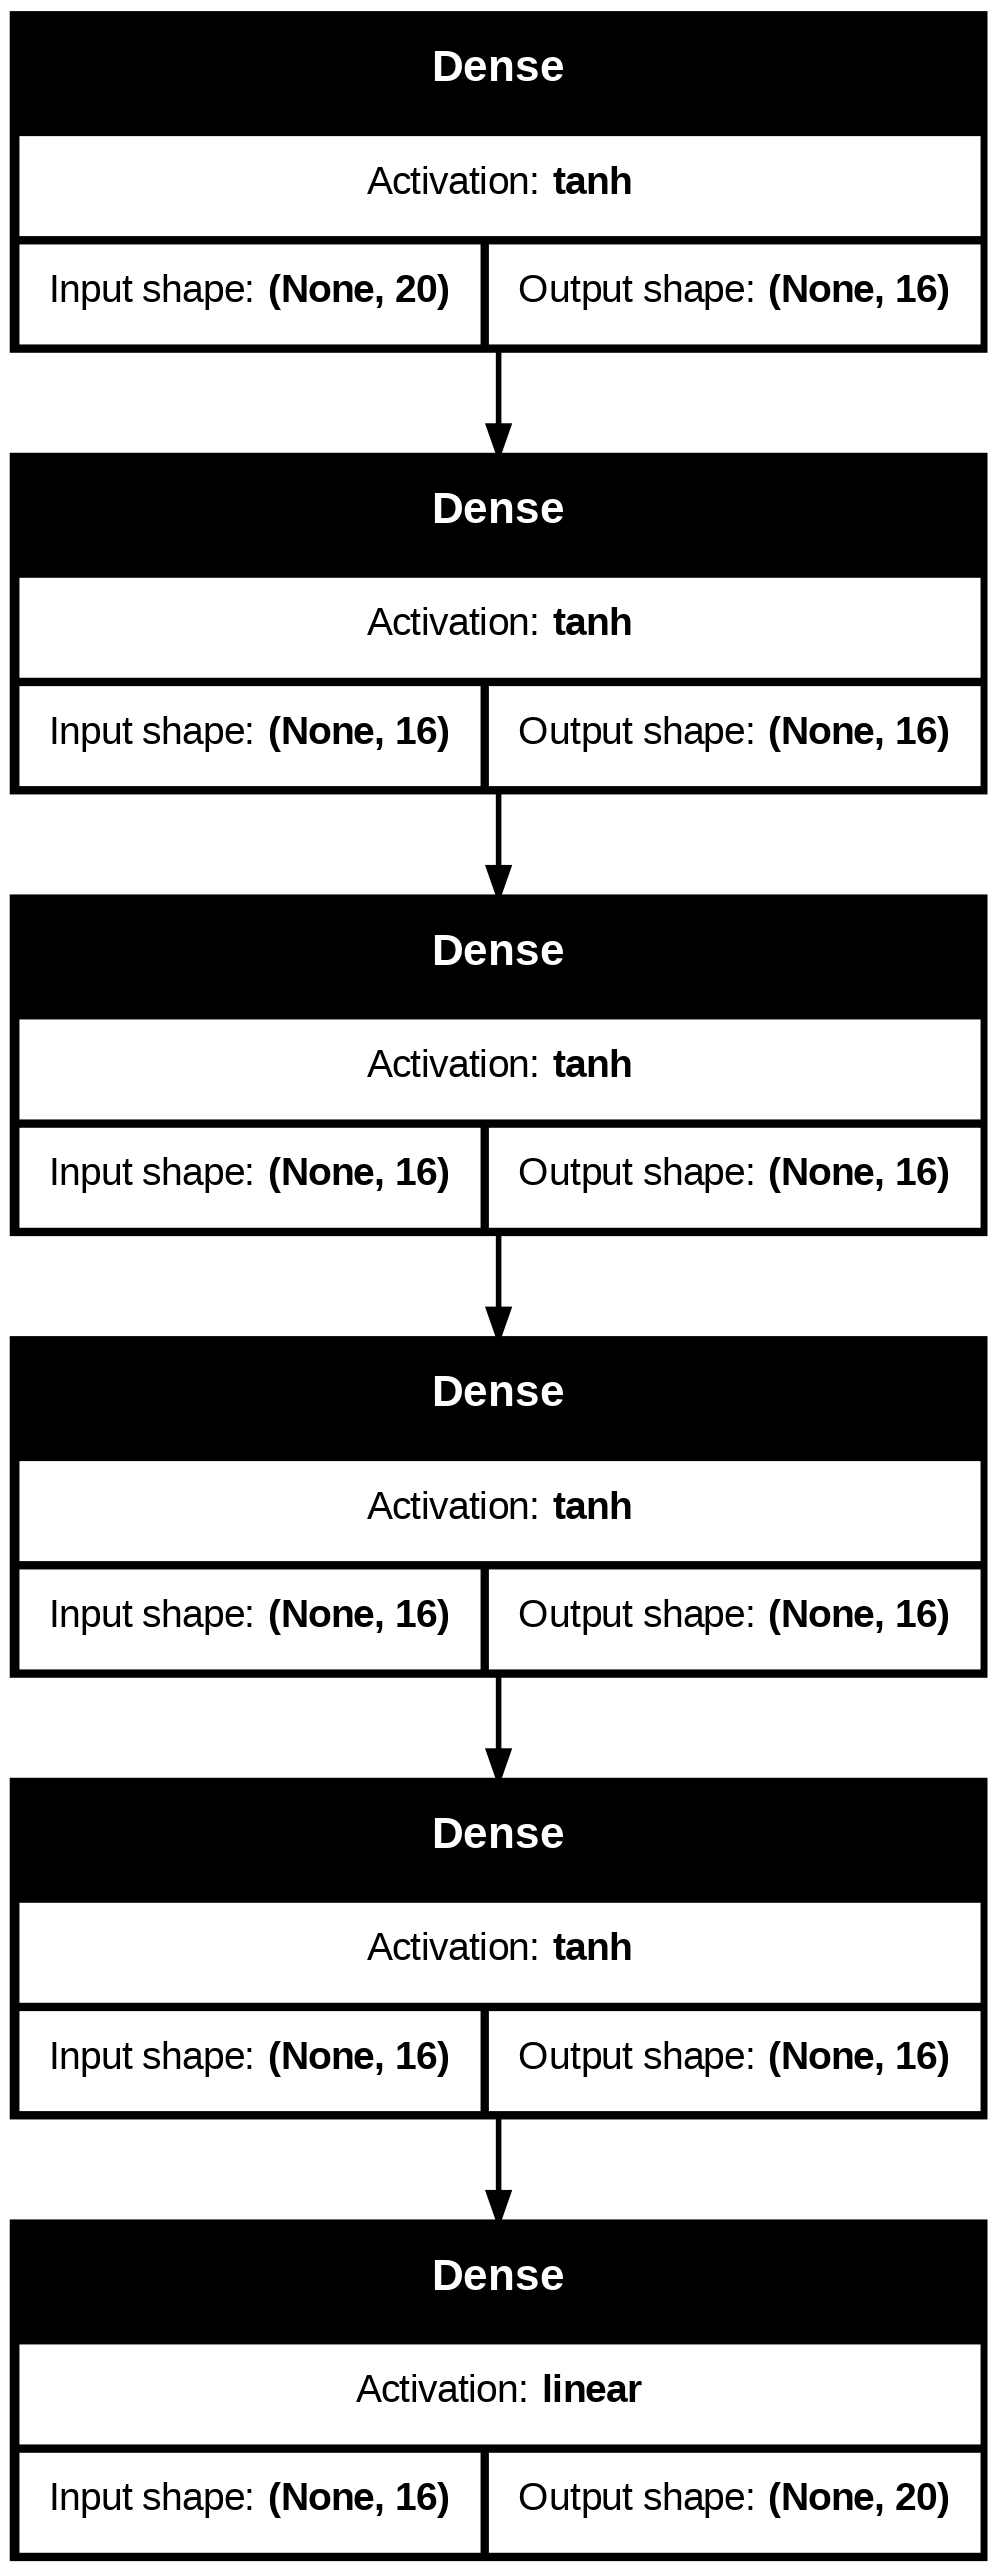

In [ ]:
# For reproducibility (delete if you want to test other random initializations)
np.random.seed(0)
tf.random.set_seed(0)

# dynamics network
input_shape = (num_latent_states,)
NNdyn = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation = tf.nn.tanh, input_shape = input_shape),
            tf.keras.layers.Dense(16, activation = tf.nn.tanh),
            tf.keras.layers.Dense(16, activation = tf.nn.tanh),
            tf.keras.layers.Dense(16, activation = tf.nn.tanh),
            tf.keras.layers.Dense(16, activation = tf.nn.tanh),
            tf.keras.layers.Dense(num_latent_states)
        ])

# summary
NNdyn.summary()

# visualization
tf.keras.utils.plot_model(NNdyn, show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [ ]:
input_shape = (None, num_latent_states + 1 + 1)

In [ ]:
def build_reconstruction(input_shape):
    input = tf.keras.layers.Input(shape=input_shape, name='Input')

    x = tf.keras.layers.Dense(16, activation = tf.math.sin)(input)
    x = tf.keras.layers.Dense(32, activation = tf.math.sin)(x)
    x = tf.keras.layers.Dense(32, activation = tf.math.sin)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(32, activation = tf.math.sin)(x)
    x = tf.keras.layers.Dense(16, activation = tf.math.sin)(x)
    x = tf.keras.layers.Dense(1, activation = tf.math.sin)(x)

    model = tf.keras.Model(inputs=input, outputs=x)

    return model

In [ ]:
NNRec = build_reconstruction(input_shape)
NNRec.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, None, 22)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, None, 16)       │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, None, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, None, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, None, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, None, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633 (28.38 KB)

 Trainable params: 3,633 (28.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def evolve_dynamics(dataset):
    # intial condition
    state = tf.zeros((1, num_latent_states), dtype=tf.float64)
    state_history = tf.TensorArray(tf.float64, size = dataset['num_times'])
    state_history = state_history.write(0, state)
    dt_ref = 5e-1

    # time integration
    for i in tf.range(dataset['num_times'] - 1):
        state = state + dt/dt_ref * NNdyn(state)
        state_history = state_history.write(i + 1, state)

    return state_history.stack()

def reconstruct_output(dataset, states):
    states_expanded = tf.broadcast_to(states,
        [dataset['num_times'], dataset['num_points'], num_latent_states])
    times_expanded = tf.broadcast_to(tf.expand_dims(tf.expand_dims(dataset['times'], axis = 1), axis= 2),
        [dataset['num_times'], dataset['num_points'], 1])
    intermediate = tf.concat((states_expanded, times_expanded), axis = 2)
    return NNRec(tf.concat([intermediate, dataset['points_full']], axis = 2))

def LDNet(dataset):
    states = evolve_dynamics(dataset)
    return reconstruct_output(dataset, states)

In [ ]:
def MSE(dataset):
    out_fields = LDNet(dataset)
    error = out_fields - dataset['out_fields']
    return tf.reduce_mean(tf.square(error))

def loss(): return MSE(dataset_train)
def MSE_valid(): return MSE(dataset_test)

In [ ]:
dataset_train['times'].shape

(257,)

# Training

In [ ]:
trainable_variables = NNdyn.variables + NNRec.trainable_variables
opt = optimization.OptimizationProblem(trainable_variables, loss, MSE_valid)

num_epochs_Adam = 50
num_epochs_BFGS = 200

print('training (Adam)...')
opt.optimize_keras(num_epochs_Adam, tf.keras.optimizers.Adam(learning_rate=1e-2))
print('training (BFGS)...')
opt.optimize_BFGS(num_epochs_BFGS)

Tracing functions with autograph...
Tracing completed.
epoch    0   -   training loss: 6.360e-01   -   validation loss 6.593e-01
training (Adam)...
epoch   10   -   training loss: 1.220e-01   -   validation loss 1.549e-01
epoch   20   -   training loss: 1.051e-01   -   validation loss 1.380e-01
epoch   30   -   training loss: 1.006e-01   -   validation loss 1.329e-01
epoch   40   -   training loss: 9.952e-02   -   validation loss 1.314e-01
epoch   50   -   training loss: 9.889e-02   -   validation loss 1.311e-01
training (BFGS)...
epoch   60   -   training loss: 9.827e-02   -   validation loss 1.309e-01
epoch   70   -   training loss: 9.803e-02   -   validation loss 1.308e-01


KeyboardInterrupt: 

# Testing

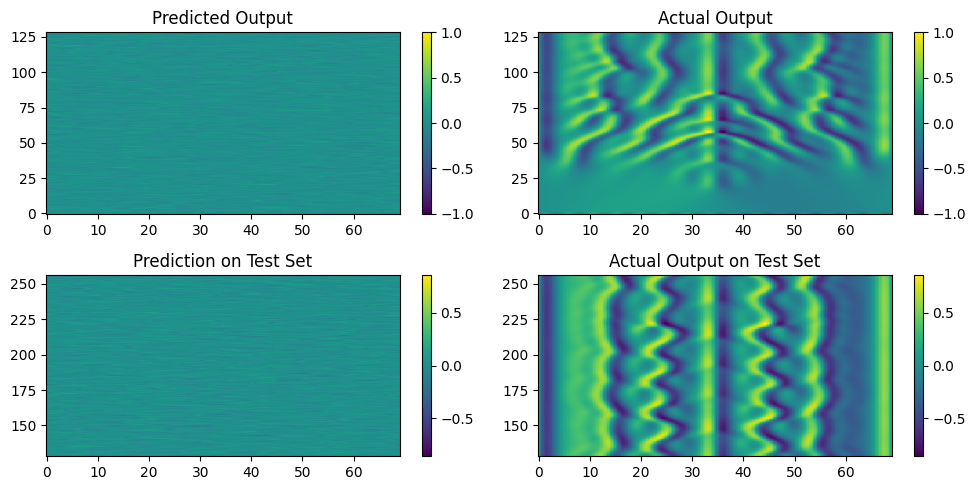

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

t = dataset_train['times'].reshape(-1)
x = dataset_train['points'].reshape(-1)
X, T = np.meshgrid(x,t)

min = np.min(dataset_train['out_fields'])
max = np.max(dataset_train['out_fields'])

im1 = axes[0][0].pcolormesh(X, T, np.squeeze(LDNet(dataset_train), axis = 2), vmin = min, vmax = max)
axes[0][0].set_title('Predicted Output')
fig.colorbar(im1, ax=axes[0][0])

im2 = axes[0][1].pcolormesh(X, T, np.squeeze(dataset_train['out_fields'], axis = 2), vmin = min, vmax = max)
axes[0][1].set_title('Actual Output')
fig.colorbar(im2, ax=axes[0][1])

t = dataset_test['times'].reshape(-1)
X, T = np.meshgrid(x,t)

min = np.min(dataset_test['out_fields'])
max = np.max(dataset_test['out_fields'])

im3 = axes[1][0].pcolormesh(X, T, np.squeeze(LDNet(dataset_test), axis = 2), vmin = min, vmax = max)
axes[1][0].set_title('Prediction on Test Set')
fig.colorbar(im3, ax=axes[1][0])

im4 = axes[1][1].pcolormesh(X, T, np.squeeze(dataset_test['out_fields'], axis = 2), vmin = min, vmax = max)
axes[1][1].set_title('Actual Output on Test Set')
fig.colorbar(im4, ax=axes[1][1])

plt.tight_layout()
plt.show()